In [1]:
# MTREND

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

In [2]:
pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

In [3]:
import sys

sys.path.append("..")
from tooling.enums import AssetClass, Index, Spot, StrikeSpread
from tooling.fetch import fetch_option_data, fetch_spot_data
from tooling.filter import find_atm, option_tool

In [4]:
def get_expiry(f_today):
    days_to_thursday = (3 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


def get_option_contract_name(symbol, strike, expiry, opt_type):
    temp = "0"
    mth = expiry.month

    if (expiry + dt.timedelta(days=7)).month != expiry.month:
        date_string = expiry.strftime("%y%b").upper()
        return f"{symbol}{date_string}{strike}{opt_type}"
    else:
        if expiry.day <= 9:
            date_string = f"{expiry.year - 2000}{mth}{temp}{expiry.day}"
        else:
            date_string = f"{expiry.year - 2000}{mth}{expiry.day}"
        return f"{symbol}{date_string}{strike}{opt_type}"

In [5]:
bnf_pandas = pd.read_csv("../data/bnf_min (2).csv")

# INDEX = 'MIDCP'
INDEX = 'BNF'
# INDEX = 'NIFTY'
# INDEX = 'FNF'
# INDEX = 'STOCK'
# INDEX = 'SENSEX'

# lev_ = 1
INDEX_ = INDEX

if INDEX == 'BNF':
    lev_ = 6
    # lev_ = 4
    slippage_ = 0.0001
    lot_size_ = 30
    sma_ = 48
    tma_ = 18
    candles_ = 1
elif INDEX == 'NIFTY':
    lev_ = 7.5
    # lev_ = 5
    slippage_ = 0.0002
    lot_size_ = 75
    sma_ = 32
    tma_ = 40
    candles_ = 1
elif INDEX == 'MIDCP':
    lev_ = 4.5
    # lev_ = 5
    slippage_ = 0.0005
    lot_size_ = 120
    sma_ = 9
    tma_ = 68
    candles_ = 1
elif INDEX == 'SENSEX':
    lev_ = 7.5
    # lev_ = 5
    slippage_ = 0.0001
    lot_size_ = 20
    sma_ = 45
    tma_ = 16
    candles_ = 1
elif INDEX == 'STOCK':
    lev_ = 5
    slippage_ = 0.001
    lot_size_ = 1
# bnf_pandas = pd.read_csv("../data/finnifty_1hr_tv (2).csv")
# bnf_pandas = pd.read_csv('../data/midcp_1hr_tv (4).csv')
# bnf_pandas = pd.read_csv('../data/finnifty_1hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/bnf_fut_1hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/gold_4hr_tv.csv')


In [6]:
bnf_pandas['datetime'] = pd.to_datetime(bnf_pandas['datetime'])
bnf_pandas = bnf_pandas[bnf_pandas['datetime'].dt.time <= dt.time(15, 29)]
bnf_pandas.tail()

index            datetime       open       high        low      close  \
777566   bnf 2025-05-30 15:25:00 55761.5500 55766.6000 55759.4000 55763.0500   
777567   bnf 2025-05-30 15:26:00 55763.2500 55765.8000 55730.1000 55731.4500   
777568   bnf 2025-05-30 15:27:00 55732.2000 55760.5500 55729.0500 55758.1500   
777569   bnf 2025-05-30 15:28:00 55757.8500 55772.9500 55737.7000 55771.3500   
777570   bnf 2025-05-30 15:29:00 55762.6000 55778.9000 55734.4000 55755.7000   

        volume  
777566       0  
777567       0  
777568       0  
777569       0  
777570       0

In [7]:
def parse_timeframe(timeframe: str) -> pl.duration:
    if timeframe.endswith('m'):
        return pl.duration(minutes=int(timeframe[:-1]))
    elif timeframe.endswith('h'):
        return pl.duration(hours=int(timeframe[:-1]))
    # Add more cases if needed
    else:
        raise ValueError(f"Unknown timeframe format: {timeframe}")

def resample(data: pl.DataFrame, timeframe: str, offset: str = '0m') -> pl.DataFrame:
    # data = data.with_columns(
    #     pl.col("datetime").str.strptime(pl.Datetime, strict=False)   # <-- fix here
    # )
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            label="left",
            offset=offset,
        )
        .agg(
            [
                pl.col("open").first().alias("open"),
                pl.col("high").max().alias("high"),
                pl.col("low").min().alias("low"),
                pl.col("close").last().alias("close"),
                pl.col("volume").sum().alias("volume"),
            ]
        )
    )


In [8]:
bnf = pl.DataFrame(bnf_pandas)
bnf_1hr = resample(bnf, '60m', '15m')   # offset can be '0m' if you want no offset
bnf = bnf_1hr

In [9]:
bnf.tail(100)

shape: (100, 6)
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┬────────┐
│ datetime            ┆ open     ┆ high     ┆ low      ┆ close    ┆ volume │
│ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---    │
│ datetime[ns]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ i64    │
╞═════════════════════╪══════════╪══════════╪══════════╪══════════╪════════╡
│ 2025-05-12 14:15:00 ┆ 55289.75 ┆ 55377.0  ┆ 55227.75 ┆ 55325.0  ┆ 0      │
│ 2025-05-12 15:15:00 ┆ 55324.7  ┆ 55466.3  ┆ 55320.65 ┆ 55411.3  ┆ 0      │
│ 2025-05-13 09:15:00 ┆ 55233.5  ┆ 55499.65 ┆ 54981.9  ┆ 55182.05 ┆ 0      │
│ 2025-05-13 10:15:00 ┆ 55176.35 ┆ 55314.0  ┆ 54944.9  ┆ 55108.8  ┆ 0      │
│ 2025-05-13 11:15:00 ┆ 55107.7  ┆ 55332.0  ┆ 55087.85 ┆ 55171.35 ┆ 0      │
│ 2025-05-13 12:15:00 ┆ 55168.35 ┆ 55211.55 ┆ 54924.9  ┆ 54990.8  ┆ 0      │
│ 2025-05-13 13:15:00 ┆ 54986.95 ┆ 54997.05 ┆ 54889.2  ┆ 54947.3  ┆ 0      │
│ 2025-05-13 14:15:00 ┆ 54946.5  ┆ 55038.05 ┆ 54894.45 ┆ 54929.7  ┆ 0      │
│ 2025-05-13 15:15:00 ┆ 54929.7  ┆ 54984.65 ┆ 54888.5  ┆ 54964.45 ┆ 0      │
│ 2025-05-14 09:15:00 ┆ 55008.55 ┆ 55208.6  ┆ 54885.15 ┆ 55089.3  ┆ 0      │
│ 2025-05-14 10:15:00 ┆ 55084.55 ┆ 55094.1  ┆ 54951.65 ┆ 55012.85 ┆ 0      │
│ 2025-05-14 11:15:00 ┆ 55008.35 ┆ 55033.95 ┆ 54805.2  ┆ 54842.85 ┆ 0      │
│ 2025-05-14 12:15:00 ┆ 54842.3  ┆ 54845.0  ┆ 54491.0  ┆ 54682.95 ┆ 0      │
│ 2025-05-14 13:15:00 ┆ 54682.85 ┆ 54711.55 ┆ 54582.7  ┆ 54654.95 ┆ 0      │
│ 2025-05-14 14:15:00 ┆ 54655.15 ┆ 54831.2  ┆ 54578.6  ┆ 54808.15 ┆ 0      │
│ 2025-05-14 15:15:00 ┆ 54810.8  ┆ 54898.8  ┆ 54759.4  ┆ 54860.55 ┆ 0      │
│ 2025-05-15 09:15:00 ┆ 54853.7  ┆ 54935.15 ┆ 54442.3  ┆ 54562.75 ┆ 0      │
│ 2025-05-15 10:15:00 ┆ 54553.8  ┆ 55019.05 ┆ 54491.3  ┆ 54616.7  ┆ 0      │
│ 2025-05-15 11:15:00 ┆ 54617.1  ┆ 54807.0  ┆ 54570.7  ┆ 54711.7  ┆ 0      │
│ 2025-05-15 12:15:00 ┆ 54715.15 ┆ 55100.3  ┆ 54629.65 ┆ 55100.3  ┆ 0      │
│ 2025-05-15 13:15:00 ┆ 55098.8  ┆ 55462.85 ┆ 55017.75 ┆ 55427.7  ┆ 0      │
│ 2025-05-15 14:15:00 ┆ 55431.55 ┆ 55490.55 ┆ 55302.9  ┆ 55362.55 ┆ 0      │
│ 2025-05-15 15:15:00 ┆ 55362.55 ┆ 55375.9  ┆ 55319.55 ┆ 55336.7  ┆ 0      │
│ 2025-05-16 09:15:00 ┆ 55276.0  ┆ 55418.9  ┆ 55170.25 ┆ 55277.45 ┆ 0      │
│ 2025-05-16 10:15:00 ┆ 55280.25 ┆ 55350.45 ┆ 55220.05 ┆ 55273.5  ┆ 0      │
│ 2025-05-16 11:15:00 ┆ 55271.55 ┆ 55315.4  ┆ 55242.55 ┆ 55263.05 ┆ 0      │
│ 2025-05-16 12:15:00 ┆ 55257.9  ┆ 55359.35 ┆ 55230.2  ┆ 55306.3  ┆ 0      │
│ 2025-05-16 13:15:00 ┆ 55306.4  ┆ 55381.15 ┆ 55276.1  ┆ 55347.3  ┆ 0      │
│ 2025-05-16 14:15:00 ┆ 55339.7  ┆ 55394.7  ┆ 55313.25 ┆ 55363.1  ┆ 0      │
│ 2025-05-16 15:15:00 ┆ 55363.1  ┆ 55376.75 ┆ 55311.0  ┆ 55350.8  ┆ 0      │
│ 2025-05-19 09:15:00 ┆ 55326.05 ┆ 55512.95 ┆ 55296.55 ┆ 55480.95 ┆ 0      │
│ 2025-05-19 10:15:00 ┆ 55478.0  ┆ 55650.25 ┆ 55474.45 ┆ 55587.35 ┆ 0      │
│ 2025-05-19 11:15:00 ┆ 55588.35 ┆ 55671.5  ┆ 55542.2  ┆ 55591.7  ┆ 0      │
│ 2025-05-19 12:15:00 ┆ 55592.4  ┆ 55695.55 ┆ 55522.15 ┆ 55542.05 ┆ 0      │
│ 2025-05-19 13:15:00 ┆ 55542.05 ┆ 55599.5  ┆ 55355.9  ┆ 55399.6  ┆ 0      │
│ 2025-05-19 14:15:00 ┆ 55400.75 ┆ 55457.5  ┆ 55303.65 ┆ 55417.1  ┆ 0      │
│ 2025-05-19 15:15:00 ┆ 55417.1  ┆ 55450.95 ┆ 55376.95 ┆ 55400.65 ┆ 0      │
│ 2025-05-20 09:15:00 ┆ 55445.3  ┆ 55568.35 ┆ 55120.35 ┆ 55194.4  ┆ 0      │
│ 2025-05-20 10:15:00 ┆ 55196.05 ┆ 55344.95 ┆ 55140.3  ┆ 55208.3  ┆ 0      │
│ 2025-05-20 11:15:00 ┆ 55208.1  ┆ 55209.45 ┆ 55071.65 ┆ 55122.2  ┆ 0      │
│ 2025-05-20 12:15:00 ┆ 55131.15 ┆ 55209.05 ┆ 55005.4  ┆ 55009.65 ┆ 0      │
│ 2025-05-20 13:15:00 ┆ 55009.4  ┆ 55049.6  ┆ 54931.7  ┆ 54965.5  ┆ 0      │
│ 2025-05-20 14:15:00 ┆ 54962.9  ┆ 54975.05 ┆ 54829.45 ┆ 54910.25 ┆ 0      │
│ 2025-05-20 15:15:00 ┆ 54910.85 ┆ 54934.3  ┆ 54854.4  ┆ 54932.35 ┆ 0      │
│ 2025-05-21 09:15:00 ┆ 55060.2  ┆ 55266.55 ┆ 54931.3  ┆ 55260.3  ┆ 0      │
│ 2025-05-21 10:15:00 ┆ 55261.0  ┆ 55336.85 ┆ 55163.85 ┆ 55218.1  ┆ 0      │
│ 2025-05-21 11:15:00 ┆ 55219.25 ┆ 55233.85 ┆ 54789.9  ┆ 

In [10]:
def generate_signals1(df, signal_ma, trailing_ma, candles_in_num):
    df["c"] = pd.to_numeric(df["c"], errors="coerce")
    df["MA20"] = df["c"].rolling(window=signal_ma).mean()
    df["MA10"] = df["c"].rolling(window=trailing_ma).mean()

    df["Buy_Signal"] = 0

    # Generate signals using boolean masking
    buy_signal_mask = df["MA20"] > df["MA20"].shift(1)
    
    for i in range(1, candles_in_num):
        buy_signal_mask &= df["MA20"].shift(i) > df["MA20"].shift(i + 1)

    df.loc[buy_signal_mask, "Buy_Signal"] = 1

    return df

In [11]:
def generate_signals2(df, i, j, candles_in_num):
    df["c"] = pd.to_numeric(df["c"], errors="coerce")
    df["MA20"] = df["c"].rolling(window=i).mean()
    df["MA10"] = df["c"].rolling(window=j).mean()

    df["Sell_Signal"] = 0

    # Generate signals using boolean masking
    sell_signal_mask = df["MA20"] < df["MA20"].shift(1)

    for i in range(1, candles_in_num):
        sell_signal_mask &= df["MA20"].shift(i) < df["MA20"].shift(i + 1)

    df.loc[sell_signal_mask, "Sell_Signal"] = 1

    return df

In [12]:
# # Positional

# def execute(df):

#     trade_book = []
#     in_trade = False
#     signal_entry_price = 100000
#     signal_initial_sl = 0
#     already_signal_exists = False
#     is_trailing_active = False
#     remark = ""
#     portfolio_value = 6250000
#     previous_trade_exit_time = None

#     for i in range(1, len(df)):
#         points = 0
#         current_candle_open = df.iloc[i]["o"]
#         current_candle_high = df.iloc[i]["h"]
#         current_candle_low = df.iloc[i]["l"]
#         current_candle_close = df.iloc[i]["c"]
#         current_candle_datetime = df.iloc[i]['datetime']
#         current_moving_average_price = df.iloc[i]["MA10"]

#         if not in_trade:
#             if df.iloc[i]["Buy_Signal"] == 1 and current_candle_datetime.time() < dt.time(15, 15):
#                 if not already_signal_exists:
#                     # Fresh Buy Signal
#                     # print(df.iloc[i])
#                     # print('Fresh Buy Signal')
#                     signal_entry_price = current_candle_high
#                     signal_initial_sl = current_candle_low
#                     signal_creation_time = df.iloc[i]["datetime"]
#                     already_signal_exists = True

#                     # if (signal_entry_price - signal_initial_sl > 400):
#                     #     # Skip Signal Candle Due To Big Size
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0

#                 else:
#                     # if current_candle_open > signal_entry_price:
#                     #     # Gap Up Open, SKIP trade
#                     #     # print(df.iloc[i])
#                     #     # print('Gap Up Open, Skip Trade')
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0
#                     if current_candle_high < signal_entry_price:
#                         # Better Candle
#                         # print(df.iloc[i])
#                         # print('Better Candle')
#                         signal_entry_price = current_candle_high
#                         signal_initial_sl = current_candle_low
#                         signal_creation_time = df.iloc[i]["datetime"]

#                         # if (signal_entry_price - signal_initial_sl > 400):
#                         #     # Skip Signal Candle Due To Big Size
#                         #     already_signal_exists = False
#                         #     signal_entry_price = 100000
#                         #     signal_initial_sl = 0

#                     elif current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
#                         # Entry Triggered
#                         # print(df.iloc[i])
#                         # print('Entry Triggered')
#                         in_trade = True
#                         entry_time = df.iloc[i]["datetime"]
#                         entry_price = signal_entry_price
#                         points = 0
#             else:
#                 if df.iloc[i - 1]["Buy_Signal"] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
#                     # Considering the forward bias condition as well now
#                     signal_entry_price = df.iloc[i - 1]["h"]
#                     signal_initial_sl = df.iloc[i - 1]["l"]
#                     signal_creation_time = df.iloc[i - 1]["datetime"]
#                     already_signal_exists = True

#                     # if current_candle_open > signal_entry_price:
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0

#                     if current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
#                         if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
#                             in_trade = True
#                             entry_time = df.iloc[i]["datetime"]
#                             entry_price = signal_entry_price
#                             points = 0
#                     else:
#                         # Discard Existing Signal
#                         already_signal_exists = False
#                         signal_entry_price = 100000
#                         signal_initial_sl = 0

#             # if df.iloc[i-1]["Buy_Signal"] == 1:
#             #     signal_entry_price = df.iloc[i-1]['h']
#             #     signal_initial_sl = df.iloc[i-1]['l']
#             #     signal_creation_time = df.iloc[i-1]["datetime"]

#             #     if current_candle_open > signal_entry_price:
#             #         # Gap Up Open, SKIP trade
#             #         already_signal_exists = False
#             #         signal_entry_price = 100000
#             #         signal_initial_sl = 0
                
#             #     elif current_candle_high >= signal_entry_price:
#             #         # Entry Triggered
#             #         in_trade = True
#             #         entry_time = df.iloc[i]["datetime"]
#             #         entry_price = signal_entry_price
#             #         points = 0

#         if in_trade:
#             trade_entry_price = signal_entry_price
#             trade_initial_sl = signal_initial_sl
#             trade_final_sl = signal_initial_sl

#             if (
#                 not is_trailing_active
#                 and current_candle_low > current_moving_average_price
#             ):
#                 is_trailing_active = True

#             if not is_trailing_active:
#                 if current_candle_open < trade_initial_sl:
#                     # if df.iloc[i-1]['l'] < trade_initial_sl:
#                     #     #Previous Candle Already Hit the SL Hence don't check gap down
#                     #     print(df.iloc[i])
#                     #     print('Initial SL Hit Before Gap Down')
#                     #     in_trade = False
#                     #     points = trade_initial_sl - trade_entry_price
#                     #     exit_price = trade_initial_sl
#                     #     exit_time = df.iloc[i-1]['datetime']
#                     #     remark = 'Initial SL Hit Before Gap Down'
#                     # else:
#                     if (
#                         df.iloc[i]["datetime"].date() == entry_time.date()
#                         and df.iloc[i]["datetime"].time() == entry_time.time()
#                     ):
#                         if current_candle_close <= trade_initial_sl:
#                             in_trade = False
#                             points = trade_initial_sl - trade_entry_price
#                             exit_price = trade_initial_sl
#                             exit_time = df.iloc[i]["datetime"]
#                             remark = "Initial SL hit"

#                     else:
#                         # Gap Open Outside ISL
#                         # print(df.iloc[i])
#                         # print('Gap Open Outside ISL')
#                         in_trade = False
#                         points = current_candle_open - trade_entry_price
#                         exit_price = current_candle_open
#                         exit_time = df.iloc[i]["datetime"]
#                         remark = "Gap Open Outside ISL"

#                 elif current_candle_low <= trade_initial_sl:
#                     # Initial SL Hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = trade_initial_sl - trade_entry_price
#                     exit_price = trade_initial_sl
#                     exit_time = df.iloc[i]["datetime"]
#                     remark = "Initial SL Hit"

#             else:
#                 trade_final_sl = max(trade_initial_sl, current_moving_average_price)

#                 if current_candle_open <= trade_initial_sl:
#                     # if df.iloc[i-1]['l'] < trade_initial_sl:
#                     #     #Previous Candle Already Hit the SL Hence don't check gap down
#                     #     print(df.iloc[i])
#                     #     print('Initial SL Hit Before Gap Down')
#                     #     in_trade = False
#                     #     points = trade_initial_sl - trade_entry_price
#                     #     exit_price = trade_initial_sl
#                     #     exit_time = df.iloc[i-1]['datetime']
#                     #     remark = 'Initial SL Hit'
#                     # else:
#                     if (
#                         df.iloc[i]["datetime"].date() == entry_time.date()
#                         and df.iloc[i]["datetime"].time() == entry_time.time()
#                     ):
#                         if current_candle_close <= trade_initial_sl:
#                             in_trade = False
#                             points = trade_initial_sl - trade_entry_price
#                             exit_price = trade_initial_sl
#                             exit_time = df.iloc[i]["datetime"]
#                             remark = "Initial SL hit"

#                     else:
#                         # Gap Open Outside ISL
#                         # print(df.iloc[i])
#                         # print('Gap Open Outside ISL')
#                         in_trade = False
#                         points = current_candle_open - trade_entry_price
#                         exit_price = current_candle_open
#                         exit_time = df.iloc[i]["datetime"]
#                         remark = "Gap Open Outside ISL"

#                 elif current_candle_low <= trade_initial_sl:
#                     # if trade_initial_sl >= current_moving_average_price:
#                     # Despite Trailing, Initial SL hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = trade_initial_sl - trade_entry_price
#                     exit_price = trade_initial_sl
#                     exit_time = df.iloc[i]["datetime"]
#                     remark = "Initial SL hit"

#                 elif current_candle_close <= trade_final_sl:
#                     # Price Closed below TSL i.e. MA10 , TSL Hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = current_candle_close - trade_entry_price
#                     exit_price = current_candle_close
#                     exit_time = df.iloc[i]["datetime"]
#                     is_trailing_active = False
#                     remark = "TSL Hit"

#             if points:
#                 index_lev = lev_
#                 qty = int(round(portfolio_value * index_lev / entry_price / lot_size_)) * lot_size_
#                 slippage = slippage_ * (entry_price + exit_price)
#                 # slippage = 10
#                 final_points = points - slippage
#                 # final_points = points
#                 previous_trade_exit_time = exit_time
#                 trade = {
#                     "Signal Generated At": signal_creation_time,
#                     "Trade Type": "LONG",
#                     "Entry Time": entry_time,
#                     "Entry Price": entry_price,
#                     "Initial SL": trade_initial_sl,
#                     "Final SL": trade_final_sl,
#                     "Exit Time": exit_time,
#                     "Exit Price": exit_price,
#                     "Points Captured": points,
#                     "After Costs": final_points,
#                     "PnL": final_points * qty,
#                     "Remarks": remark,
#                     "Qty": qty,
#                     "Leverage": index_lev,
#                     "ROI%": (final_points * qty / portfolio_value) * 100,
#                     "Trade Year": entry_time.year,
#                     "Trade Month": entry_time.month,
#                 }
#                 trade_book.append(trade)
#                 points = 0
#                 in_trade = False
#                 already_signal_exists = False
#                 remark = ""
#                 is_trailing_active = False

#     trade_book_df = pd.DataFrame(trade_book)
#     return trade_book_df

In [32]:
# Positional

def execute(df):

    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    is_trailing_active = False
    remark = ""
    portfolio_value = 3750000
    previous_trade_exit_time = None

    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_candle_datetime = df.iloc[i]['datetime']
        current_moving_average_price = df.iloc[i]["MA10"]

        if current_candle_datetime.time() == dt.time(15, 15):
            df.iloc[i]['Buy_Signal'] = 0
            # continue
        if not in_trade:
            if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
                if df.iloc[i-1]['Buy_Signal'] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
                    signal_entry_price = df.iloc[i-1]['h']
                    signal_initial_sl = df.iloc[i-1]['l']
                    signal_creation_time = df.iloc[i-1]['datetime']
                    if current_candle_high >= signal_entry_price:
                        #Entry Triggered
                        entry_price = signal_entry_price
                        entry_time = current_candle_datetime
                        in_trade = True

        # if not in_trade:
        #     if current_candle_datetime.time() == dt.time(15, 15):
        #         df.iloc[i]["Buy_Signal"] = 0
        #         continue
        #     if df.iloc[i]["Buy_Signal"] == 1 and current_candle_datetime.time() < dt.time(15, 15):
        #         if not already_signal_exists:
        #             # Fresh Buy Signal
        #             # print(df.iloc[i])
        #             # print('Fresh Buy Signal')
        #             signal_entry_price = current_candle_high
        #             signal_initial_sl = current_candle_low
        #             signal_creation_time = df.iloc[i]["datetime"]
        #             already_signal_exists = True

        #             # if (signal_entry_price - signal_initial_sl > 400):
        #             #     # Skip Signal Candle Due To Big Size
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0

        #         else:
        #             # if current_candle_open > signal_entry_price:
        #             #     # Gap Up Open, SKIP trade
        #             #     # print(df.iloc[i])
        #             #     # print('Gap Up Open, Skip Trade')
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0
                    
        #             if current_candle_high < signal_entry_price:
        #                 # Better Candle
        #                 # print(df.iloc[i])
        #                 # print('Better Candle')
        #                 signal_entry_price = current_candle_high
        #                 signal_initial_sl = current_candle_low
        #                 signal_creation_time = df.iloc[i]["datetime"]

        #                 # if (signal_entry_price - signal_initial_sl > 400):
        #                 #     # Skip Signal Candle Due To Big Size
        #                 #     already_signal_exists = False
        #                 #     signal_entry_price = 100000
        #                 #     signal_initial_sl = 0

        #             elif current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
        #                 # Entry Triggered
        #                 # print(df.iloc[i])
        #                 # print('Entry Triggered')
        #                 in_trade = True
        #                 entry_time = df.iloc[i]["datetime"]
        #                 entry_price = signal_entry_price
        #                 points = 0
        #     else:
        #         if df.iloc[i - 1]["Buy_Signal"] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
        #             # Considering the forward bias condition as well now
        #             signal_entry_price = df.iloc[i - 1]["h"]
        #             signal_initial_sl = df.iloc[i - 1]["l"]
        #             signal_creation_time = df.iloc[i - 1]["datetime"]
        #             already_signal_exists = True

        #             # if current_candle_open > signal_entry_price:
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0

        #             if current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
        #                 if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
        #                     in_trade = True
        #                     entry_time = df.iloc[i]["datetime"]
        #                     entry_price = signal_entry_price
        #                     points = 0
        #             else:
        #                 # Discard Existing Signal
        #                 already_signal_exists = False
        #                 signal_entry_price = 100000
        #                signal_initial_sl = 0

            # if df.iloc[i-1]["Buy_Signal"] == 1:
            #     signal_entry_price = df.iloc[i-1]['h']
            #     signal_initial_sl = df.iloc[i-1]['l']
            #     signal_creation_time = df.iloc[i-1]["datetime"]

            #     if current_candle_open > signal_entry_price:
            #         # Gap Up Open, SKIP trade
            #         already_signal_exists = False
            #         signal_entry_price = 100000
            #         signal_initial_sl = 0
                
            #     elif current_candle_high >= signal_entry_price:
            #         # Entry Triggered
            #         in_trade = True
            #         entry_time = df.iloc[i]["datetime"]
            #         entry_price = signal_entry_price
            #         points = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_low > current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open < trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit Before Gap Down'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # Initial SL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

            else:
                trade_final_sl = max(trade_initial_sl, current_moving_average_price)

                if current_candle_open <= trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # if trade_initial_sl >= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close <= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = current_candle_close - trade_entry_price
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                index_lev = lev_
                qty = int(round(portfolio_value * index_lev / entry_price / lot_size_)) * lot_size_
                slippage = slippage_ * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points
                previous_trade_exit_time = exit_time
                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "LONG",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": index_lev,
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False
                i += 1

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [33]:
bnf1 = bnf
bnf2 = bnf

In [34]:
def generate_stats(tb_expiry, signal_ma, trailing_ma):
    stats_df8 = pd.DataFrame(
        index=range(2017, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2017, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f'{signal_ma} , {trailing_ma}'
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation
    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio : stats_df8}

In [35]:
bnf1 = bnf1.to_pandas()
bnf2 = bnf2.to_pandas()

In [36]:
bnf1['datetime'] = pd.to_datetime(bnf1['datetime'])
bnf2['datetime'] = pd.to_datetime(bnf2['datetime'])

In [37]:
bnf1 = bnf1[bnf1['datetime'].dt.time >= dt.time(9, 14)]
bnf1 = bnf2[bnf2['datetime'].dt.time >= dt.time(9, 14)]

In [38]:
# bnf1.tail(650)

In [39]:
# stats_dictionary = {}

# for i in range(6, 81):
#     for j in range(4, 101, 2):
#         print(f"Signal MA : {i} , Trailing MA : {j}")
#         signals_df1 = generate_signals1(bnf1, i, j)
#         signals_df1 = signals_df1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})
#         new_tb = execute(signals_df1)
#         new_tb["DD%"] = new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
#         tradebook_buy_side = new_tb
#         stats = generate_stats(tradebook_buy_side, i, j)
#         for overall_roi_dd_ratio, stats_df in stats.items():
#             if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 10:
#                 print(stats_df.to_string())
#                 stats_dictionary[overall_roi_dd_ratio] = stats_df

In [40]:
# sorted_stats = {k: v for k, v in sorted(stats_dictionary.items(), key=lambda item: item[0], reverse=True)}
# sorted_stats

In [41]:
bnf1 = bnf1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})

In [42]:
sma = 56
tma = 15
candles = 1
variation = f'{INDEX}, {sma} , {tma} , {candles}'
signals_df1 = generate_signals1(bnf1, sma, tma, candles)

In [43]:
signals_df1.tail(13000)

datetime          o          h          l          c  volume  \
1518  2017-11-16 15:15:00 25423.1000 25494.0500 25420.9000 25490.6000       0   
1519  2017-11-17 09:15:00 25875.7000 25924.3000 25803.6000 25845.9500       0   
1520  2017-11-17 10:15:00 25849.6000 25901.8500 25844.4500 25888.1500       0   
1521  2017-11-17 11:15:00 25889.2000 25898.6500 25845.4000 25878.0000       0   
1522  2017-11-17 12:15:00 25880.2500 25899.7000 25842.9000 25864.6000       0   
1523  2017-11-17 13:15:00 25865.3000 25911.1500 25846.6500 25861.2500       0   
1524  2017-11-17 14:15:00 25860.5000 25864.5000 25743.6500 25744.6000       0   
1525  2017-11-17 15:15:00 25743.3000 25743.3000 25679.8000 25700.2500       0   
1526  2017-11-20 09:15:00 25733.7000 25797.9500 25683.2500 25730.2500       0   
1527  2017-11-20 10:15:00 25729.4000 25752.4000 25693.4000 25747.0000       0   
1528  2017-11-20 11:15:00 25746.7500 25760.3000 25719.7500 25748.7000       0   
1529  2017-11-20 12:15:00 25751.2000 25755.2000 25692.4500 25711.4500       0   
1530  2017-11-20 13:15:00 25713.4500 25753.0000 25703.1000 25748.8500       0   
1531  2017-11-20 14:15:00 25749.5000 25802.7000 25742.0500 25769.7500       0   
1532  2017-11-20 15:15:00 25770.9000 25776.4500 25751.6000 25762.6000       0   
1533  2017-11-21 09:15:00 25829.3000 25865.8000 25795.7000 25825.3000       0   
1534  2017-11-21 10:15:00 25826.1000 25870.9500 25812.6000 25841.5000       0   
1535  2017-11-21 11:15:00 25841.7000 25842.1500 25795.5000 25810.4000       0   
1536  2017-11-21 12:15:00 25811.1500 25825.7000 25769.4000 25790.7000       0   
1537  2017-11-21 13:15:00 25791.0000 25839.1500 25787.2500 25812.5500       0   
1538  2017-11-21 14:15:00 25812.7000 25813.6500 25727.4000 25758.2000       0   
1539  2017-11-21 15:15:00 25759.1000 25774.3000 25728.1500 25740.7500       0   
1540  2017-11-22 09:15:00 25805.6500 25831.7500 25669.0000 25690.7000       0   
1541  2017-11-22 10:15:00 25693.4000 25723.1500 25665.9500 25686.8000       0   
1542  2017-11-22 11:15:00 25686.7000 25781.8500 25684.3500 25757.6500       0   
1543  2017-11-22 12:15:00 25757.7500 25810.5500 25728.0000 25769.8500       0   
1544  2017-11-22 13:15:00 25769.0500 25816.8000 25763.7000 25797.7000       0   
1545  2017-11-22 14:15:00 25798.2000 25800.0000 25737.1500 25764.4500       0   
1546  2017-11-22 15:15:00 25763.6000 25783.3500 25757.3500 25761.9500       0   
1547  2017-11-23 09:15:00 25826.3000 25829.8500 25716.7000 25762.8000       0   
1548  2017-11-23 10:15:00 25763.5000 25771.1000 25719.7500 25745.9000       0   
1549  2017-11-23 11:15:00 25744.9000 25758.9000 25710.8000 25721.6000       0   
1550  2017-11-23 12:15:00 25720.8500 25723.0500 25632.0500 25632.2000       0   
1551  2017-11-23 13:15:00 25630.9500 25717.8000 25621.6000 25689.8000       0   
1552  2017-11-23 14:15:00 25686.7500 25744.8500 25669.4500 25720.6500       0   
1553  2017-11-23 15:15:00 25719.9500 25772.9000 25719.5000 25743.7500       0   
1554  2017-11-24 09:15:00 25776.6000 25848.6000 25751.3500 25808.8500       0   
1555  2017-11-24 10:15:00 25809.3500 25826.8500 25759.4500 25778.4500       0   
1556  2017-11-24 11:15:00 25779.2500 25811.2500 25757.5500 25776.3000       0   
1557  2017-11-24 12:15:00 25776.6500 25808.0000 25756.6500 25792.4000       0   
1558  2017-11-24 13:15:00 25792.4000 25837.7000 25777.1000 25779.0500       0   
1559  2017-11-24 14:15:00 25779.1500 25807.9500 25759.1500 25781.6500       0   
1560  2017-11-24 15:15:00 25782.2000 25798.5000 25765.6500 25793.4500       0   
1561  2017-11-27 09:15:00 25693.0500 25735.2500 25674.8000 25732.3000       0   
1562  2017-11-27 10:15:00 25735.4500 25764.9500 25714.5500 25729.4000       0   
1563  2017-11-27 11:15:00 25728.2500 25763.5000 25728.2500 25735.4500       0   
1564  2017-11-27 12:15:00 25735.9500 25746.4000 25710.0000 25731.9000       0   
1565  2017-11-27 13:15:00 25732.1500 25778.7500 25720.3000 25771.0000       0   
1566  2017-11-27 14:15:00 25772.9000 25897.9500 

In [44]:

new_tb = execute(signals_df1)
# new_tb["DD%"] = new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
tradebook_buy_side = new_tb
# new_tb

/tmp/ipykernel_15974/3715834428.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[i]['Buy_Signal'] = 0


In [45]:
# tradebook_buy_side['DD%'] = (tradebook_buy_side['ROI%'].cumsum() - tradebook_buy_side['ROI%'].cumsum().cummax())
# tradebook_buy_side

In [46]:
new_tb

Signal Generated At Trade Type          Entry Time  Entry Price  \
0   2017-01-12 10:15:00       LONG 2017-01-12 11:15:00   18888.0500   
1   2017-01-13 10:15:00       LONG 2017-01-13 11:15:00   18866.4000   
2   2017-01-18 09:15:00       LONG 2017-01-18 10:15:00   19255.3500   
3   2017-01-19 10:15:00       LONG 2017-01-19 11:15:00   19108.4000   
4   2017-01-20 10:15:00       LONG 2017-01-20 11:15:00   19010.5000   
5   2017-01-23 09:15:00       LONG 2017-01-23 10:15:00   18869.9500   
6   2017-01-31 11:15:00       LONG 2017-01-31 12:15:00   19492.3000   
7   2017-02-01 09:15:00       LONG 2017-02-01 10:15:00   19613.9000   
8   2017-02-01 12:15:00       LONG 2017-02-01 13:15:00   19933.8000   
9   2017-02-08 12:15:00       LONG 2017-02-08 13:15:00   20297.3000   
10  2017-02-08 14:15:00       LONG 2017-02-08 15:15:00   20300.1000   
11  2017-02-09 11:15:00       LONG 2017-02-09 12:15:00   20108.3000   
12  2017-02-13 12:15:00       LONG 2017-02-13 13:15:00   20194.2000   
13  2017-02-14 12:15:00       LONG 2017-02-14 13:15:00   20228.7500   
14  2017-02-15 12:15:00       LONG 2017-02-15 13:15:00   20178.2500   
15  2017-02-17 10:15:00       LONG 2017-02-17 11:15:00   20707.2000   
16  2017-02-20 09:15:00       LONG 2017-02-20 10:15:00   20560.4000   
17  2017-02-27 10:15:00       LONG 2017-02-27 11:15:00   20730.3500   
18  2017-02-28 11:15:00       LONG 2017-02-28 12:15:00   20632.7000   
19  2017-03-01 13:15:00       LONG 2017-03-01 14:15:00   20791.1000   
20  2017-03-10 13:15:00       LONG 2017-03-10 14:15:00   20735.5500   
21  2017-03-17 11:15:00       LONG 2017-03-17 12:15:00   21179.3000   
22  2017-03-20 10:15:00       LONG 2017-03-20 11:15:00   21132.6000   
23  2017-03-21 12:15:00       LONG 2017-03-21 13:15:00   21028.7000   
24  2017-03-21 14:15:00       LONG 2017-03-21 15:15:00   21027.6500   
25  2017-03-22 11:15:00       LONG 2017-03-22 12:15:00   20863.7500   
26  2017-03-23 10:15:00       LONG 2017-03-23 11:15:00   20856.4500   
27  2017-03-23 13:15:00       LONG 2017-03-23 14:15:00   20849.8500   
28  2017-03-29 09:15:00       LONG 2017-03-29 10:15:00   21319.8000   
29  2017-04-03 10:15:00       LONG 2017-04-03 11:15:00   21493.3500   
30  2017-04-06 13:15:00       LONG 2017-04-06 14:15:00   21604.1500   
31  2017-04-07 09:15:00       LONG 2017-04-07 10:15:00   21605.4500   
32  2017-04-10 09:15:00       LONG 2017-04-10 10:15:00   21493.2500   
33  2017-04-13 10:15:00       LONG 2017-04-13 11:15:00   21754.1000   
34  2017-04-17 13:15:00       LONG 2017-04-17 14:15:00   21646.0000   
35  2017-04-21 10:15:00       LONG 2017-04-21 11:15:00   21564.8000   
36  2017-04-21 14:15:00       LONG 2017-04-21 15:15:00   21568.3000   
37  2017-04-28 11:15:00       LONG 2017-04-28 12:15:00   22246.7500   
38  2017-05-03 12:15:00       LONG 2017-05-03 13:15:00   22290.4500   
39  2017-05-08 09:15:00       LONG 2017-05-08 10:15:00   22779.8500   
40  2017-05-09 10:15:00       LONG 2017-05-09 11:15:00   22720.7500   
41  2017-05-12 14:15:00       LONG 2017-05-12 15:15:00   22696.3500   
42  2017-05-19 14:15:00       LONG 2017-05-19 15:15:00   22777.2000   
43  2017-05-25 12:15:00       LONG 2017-05-25 13:15:00   22833.1500   
44  2017-05-30 11:15:00       LONG 2017-05-30 12:15:00   23263.6000   
45  2017-05-30 13:15:00       LONG 2017-05-30 14:15:00   23268.9000   
46  2017-06-01 12:15:00       LONG 2017-06-01 13:15:00   23287.0500   
47  2017-06-06 12:15:00       LONG 2017-06-06 13:15:00   23436.3000   
48  2017-06-09 09:15:00       LONG 2017-06-09 10:15:00   23569.7500   
49  2017-06-13 10:15:00       LONG 2017-06-13 11:15:00   23587.9000   
50  2017-06-14 10:15:00       LONG 2017-06-14 11:15:00   23453.1000   
51  2017-06-14 12:15:00       LONG 2017-06-14 13:15:00   23526.4500   
52  2017-06-16 09:15:00       LONG 2017-06-16 10:15:00   23481.4000   
53  2017-06-19 09:15:00       LONG 2017-06-19 10:15:00   23594.5500   
54  2017-06-21 12:15:00       LONG 2017-06-21 13:15:00   23676.5000   
55  2017-06-22 09:15:00     

In [47]:
def generate_stats(tb_expiry, variation):
    stats_df8 = pd.DataFrame(
        index=range(2017, 2026),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2017, 2026):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = variation
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation

    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    
    # print(f'{overall_total_roi} , {overall_max_drawdown} , {overall_roi_dd_ratio}')
    
    return {overall_roi_dd_ratio: stats_df8}

In [48]:
final_stats = None
stats = generate_stats(tradebook_buy_side, variation)
for x, y in stats.items():
    final_stats = y

final_stats

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2017      51.8041          107  34.5794                5.3917   
2018      28.9627           94  30.8511                5.6373   
2019     110.4605           78  30.7692               11.2010   
2020     222.4151           74  32.4324               18.1910   
2021     220.4641           75  38.6667               11.8699   
2022     129.0205           95  33.6842               10.1487   
2023      88.7980           76  32.8947                7.2959   
2024      38.2623           87  25.2874                8.1517   
2025      27.8808           32  21.8750               13.3452   
Overall  918.0680          718  31.8942                9.5743   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio         Variation  
2017                -2.1099     -31.7149       1.6334  BNF, 56 , 15 , 1  
2018                -2.0695     -23.6462       1.2248  BNF, 56 , 15 , 1  
2019                -2.9327     -32.8271       3.3649  BNF, 56 , 15 , 1  
2020                -4.2834     -37.5345       5.9256  BNF, 56 , 15 , 1  
2021                -2.6905     -14.8083      14.8879  BNF, 56 , 15 , 1  
2022                -3.1069     -46.9692       2.7469  BNF, 56 , 15 , 1  
2023                -1.8353     -16.5593       5.3624  BNF, 56 , 15 , 1  
2024                -2.1704     -24.5067       1.5613  BNF, 56 , 15 , 1  
2025                -2.6214     -22.9271       1.2161  BNF, 56 , 15 , 1  
Overall             -2.6062     -46.9692      19.5462  BNF, 56 , 15 , 1

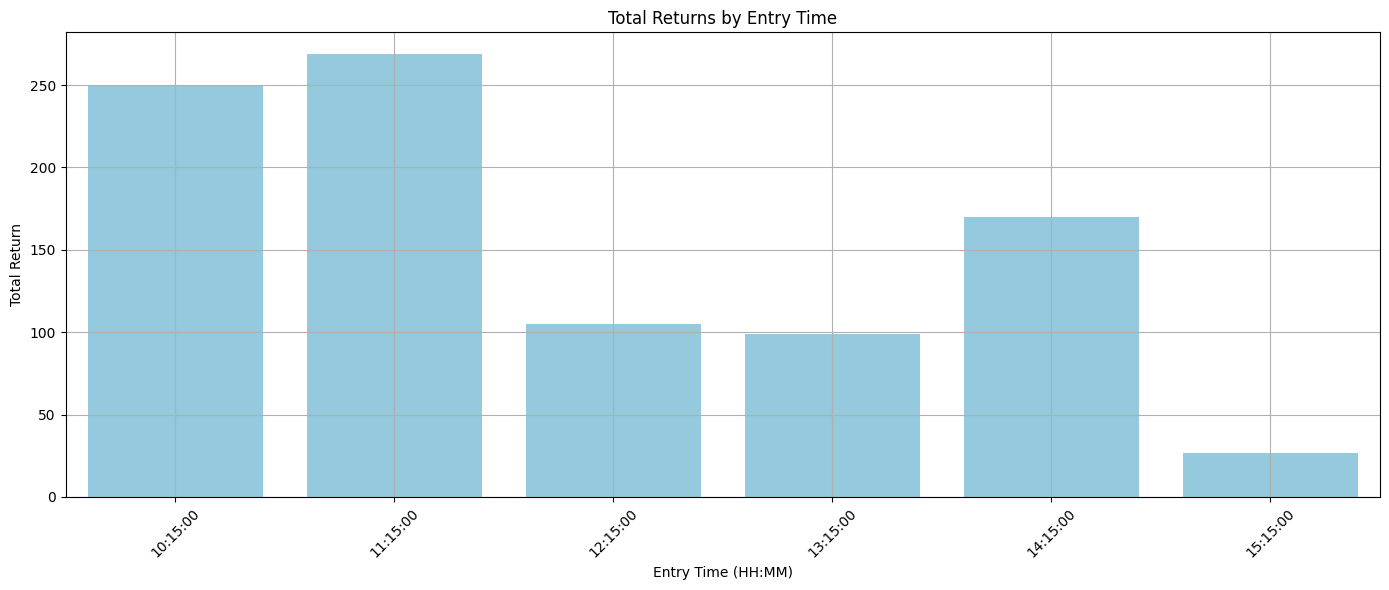

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = tradebook_buy_side.copy()  # your DataFrame

# Step 1: Convert time to string format (HH:MM) for better x-axis display
df['entry_time_str'] = df['Entry Time'].dt.time.apply(lambda t: t.strftime('%H:%M:%S'))

# Step 2: Group by time and sum the returns
agg_df = df.groupby('entry_time_str')['ROI%'].sum().reset_index()

# Step 3: Plot the summed returns by time
plt.figure(figsize=(14, 6))
sns.barplot(x='entry_time_str', y='ROI%', data=agg_df, color='skyblue')
plt.xticks(rotation=45)
plt.title('Total Returns by Entry Time')
plt.xlabel('Entry Time (HH:MM)')
plt.ylabel('Total Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
tradebook_buy_side.to_csv(f'{INDEX_}_mtrend.csv', index=False)

In [57]:
# bnf1 = bnf1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})

In [28]:
stats_dict = {}

for i in range(56, 65):
    for j in range(12, 20):
            variation = f'SMA: {i}, TMA: {j}'
            print(variation)
            signals_df1 = generate_signals1(bnf1, i, j, 1)
            new_tb = execute(signals_df1)
            stats = generate_stats(new_tb, variation)
            for overall_roi_dd_ratio, stats_df in stats.items():
                if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 15:
                    stats_dict[overall_roi_dd_ratio] = stats_df
                    print(stats_df.to_string())

SMA: 56, TMA: 12
SMA: 56, TMA: 13
SMA: 56, TMA: 14
        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio         Variation
2019     107.4900           80  28.7500               12.0580             -2.9797     -36.8345       2.9182  SMA: 56, TMA: 14
2020     202.3700           80  30.0000               18.3451             -4.2484     -45.2440       4.4729  SMA: 56, TMA: 14
2021     207.2822           76  38.1579               11.8806             -2.9203     -22.9494       9.0321  SMA: 56, TMA: 14
2022     126.3786           97  32.9897               10.0848             -3.0206     -47.7384       2.6473  SMA: 56, TMA: 14
2023      94.4553           78  35.8974                6.6644             -1.8430     -16.1025       5.8659  SMA: 56, TMA: 14
2024      35.2307           91  27.4725                6.4758             -1.9192     -17.6280       1.9986  SMA: 56, TMA: 14
2025       2.9295           18  16.6667               14.1696      

In [29]:
sorted_stats = {k: v for k, v in sorted(stats_dict.items(), key=lambda item: item[0], reverse=True)}

In [30]:
sorted_stats

{16.918184232748708:         Total ROI Total Trades Win Rate Avg Profit% per Trade  \
 2019     115.5908           77  31.1688               11.1965   
 2020     225.4096           74  32.4324               18.2370   
 2021     203.9768           74  39.1892               11.4431   
 2022     132.4775           93  34.4086               10.0851   
 2023      89.2262           77  33.7662                7.0020   
 2024      29.2346           88  25.0000                7.7907   
 2025       2.8682           18  16.6667               14.0710   
 Overall  798.7837          501  32.2397                9.3607   
 
         Avg Loss% per Trade Max Drawdown ROI/DD Ratio         Variation  
 2019                -2.8891     -32.8019       3.5239  SMA: 56, TMA: 15  
 2020                -4.2456     -37.2471       6.0517  SMA: 56, TMA: 15  
 2021                -2.8416     -17.6577      11.5517  SMA: 56, TMA: 15  
 2022                -3.1188     -47.2145       2.8059  SMA: 56, TMA: 15  
 2023    

# MTrend BNF

In [36]:
# new_tb.to_csv('BNF Mtrend New.csv', index=False)

In [139]:
# Positional Sell Side


def execute_sell_side(df):
    portfolio_value = 7500000
    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    remark = ""
    is_trailing_active = False
    previous_trade_exit_time = None

    print(lev_, slippage_, portfolio_value)
    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_moving_average_price = df.iloc[i]["MA10"]

        if not in_trade:
            if df.iloc[i]["Sell_Signal"] == 1:
                if not already_signal_exists:
                    # Fresh Sell Signal
                    # print(df.iloc[i])
                    # print('Fresh Short Sell Signal')
                    signal_entry_price = current_candle_low
                    signal_initial_sl = current_candle_high
                    signal_creation_time = df.iloc[i]["datetime"]
                    already_signal_exists = True

                    # if (signal_initial_sl - signal_entry_price > 400):
                    #     # Skip Signal Candle Due To Big Size
                    #     already_signal_exists = False
                    #     signal_entry_price = 100000
                    #     signal_initial_sl = 0

                else:
                    if current_candle_open < signal_entry_price:
                        # Gap Down Outside, SKIP trade
                        # print('Signal Entry Price' , signal_entry_price)
                        # print(df.iloc[i])
                        # print('Gap Outside, Skip Trade')
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0
                    elif current_candle_low > signal_entry_price:
                        # Better Candle
                        
                        # print(df.iloc[i])
                        # print('Better Candle')
                        signal_entry_price = current_candle_low
                        signal_initial_sl = current_candle_high
                        signal_creation_time = df.iloc[i]["datetime"]

                        # if (signal_initial_sl - signal_entry_price > 400):
                        #     # Skip Signal Candle Due To Big Size
                        #     already_signal_exists = False
                        #     signal_entry_price = 100000
                        #     signal_initial_sl = 0

                    elif current_candle_low < signal_entry_price:
                        # Entry Triggered
                        
                        # print(df.iloc[i])
                        # print('Entry Triggered')
                        in_trade = True
                        entry_time = df.iloc[i]["datetime"]
                        entry_price = signal_entry_price
                        points = 0
            else:
                if df.iloc[i - 1]["Sell_Signal"] == 1:
                    # Considering the forward bias condition as well now
                    signal_entry_price = df.iloc[i - 1]["l"]
                    signal_initial_sl = df.iloc[i - 1]["h"]
                    signal_creation_time = df.iloc[i - 1]["datetime"]
                    already_signal_exists = True

                    if current_candle_low < signal_entry_price:
                        if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
                            in_trade = True
                            entry_time = df.iloc[i]["datetime"]
                            entry_price = signal_entry_price
                            points = 0
                    else:
                        # Discard Existing Signal
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_high < current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        
                        # print(df.iloc[i])
                        # print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # Initial SL Hit
                    
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

                elif current_candle_close >= trade_final_sl:
                    # TSL Hit
                    # print(df.iloc[i])
                    # print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    remark = "TSL Hit"

            elif is_trailing_active:
                trade_final_sl = min(trade_initial_sl, current_moving_average_price)

                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        
                        # print(df.iloc[i])
                        # print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # if trade_initial_sl <= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close >= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    # print(df.iloc[i])
                    # print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                qty = int(round((portfolio_value * lev_ / entry_price) / lot_size_) * lot_size_)
                slippage = slippage_ * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points
                previous_trade_exit_time = exit_time
                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "SHORT",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": lev_,
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                # print(trade)
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [38]:
# bnf_pandas = pd.read_csv('../data/midcp_1hr_tv_new.csv')

In [39]:
# bnf_pandas.head()

In [40]:
# # If Stocks Data ...
# bnf_pandas["datetime"] = pd.to_datetime(bnf_pandas["time"])
# bnf_pandas["datetime"] = bnf_pandas["datetime"].dt.tz_localize(None)
# bnf_pandas = bnf_pandas[bnf_pandas["datetime"].dt.year >= 2017]
# bnf_pandas.drop(columns=["time"], inplace=True)
# # bnf_pandas

In [41]:
# bnf = pl.DataFrame(bnf_pandas)
# bnf = bnf.with_columns([pl.col("datetime").alias("index")]).drop("datetime")


In [42]:
# data = pl.DataFrame(data)
# data = data.with_columns([
#     pl.col("datetime").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
# ])

In [140]:
def generate_stats(tb_expiry, variation):
    stats_df8 = pd.DataFrame(
        index=range(2022, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2022, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = variation
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation
    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio : stats_df8}

In [44]:
# targets = [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 100]
# time_frames = ["3m", "5m", "10m", "15m", "30m", "60m"]
# num_candles = [1, 2, 3, 4, 5]
# for i in range(5, 81, 5):
#     for j in range(5, 81, 5):
#         for k in targets:
#             for tf in time_frames:
#                 for candles in num_candles:
#                     if tf == "10m":
#                         offset = "5m"
#                     elif tf == "30m" or tf == "60m":
#                         offset = "15m"
#                     else:
#                         offset = "0m"
#                     variation = f"SMA: {i}, TMA: {j}, Target: {k}R, TF: {tf}, Candles: {candles}"
#                     print(variation)
#                     data_w_signals = (resample(data, tf, offset)).to_pandas()
#                     data_w_signals = generate_signals2(data_w_signals, i, j, candles)
#                     data_w_signals2 = data_w_signals.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})
#                     sell_tb = execute_sell_side(data_w_signals2)
#                     stats = generate_stats(sell_tb, variation)
#                     for overall_roi_dd_ratio, stats_df in stats.items():
#                         if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 3:
#                             print(stats_df.to_string())
#                             stats_dictionary[overall_roi_dd_ratio] = stats_df

In [ ]:
# tradebook_sell_side

In [45]:
# bnf_pandas.head()

In [180]:
signals_df1 = generate_signals2(bnf1, 50, 49, 5)
tradebook_sell_side = execute_sell_side(signals_df1)

3 0.0005 7500000


In [182]:
# tradebook_sell_side = tradebook_sell_side[154:]
tradebook_sell_side

Signal Generated At Trade Type          Entry Time  Entry Price  \
0  2022-01-21 10:15:00      SHORT 2022-01-21 11:15:00    7616.7500   
1  2022-01-28 11:15:00      SHORT 2022-01-28 12:15:00    7548.7000   
2  2022-01-31 13:15:00      SHORT 2022-01-31 14:15:00    7514.1500   
3  2022-02-01 10:15:00      SHORT 2022-02-01 11:15:00    7560.3500   
4  2022-02-09 15:15:00      SHORT 2022-02-10 09:15:00    7505.7000   
5  2022-02-10 12:15:00      SHORT 2022-02-10 13:15:00    7548.0500   
6  2022-03-03 11:15:00      SHORT 2022-03-03 12:15:00    6978.0500   
7  2022-03-11 12:15:00      SHORT 2022-03-11 13:15:00    6885.2000   
8  2022-03-11 15:15:00      SHORT 2022-03-14 09:15:00    6930.3500   
9  2022-04-19 11:15:00      SHORT 2022-04-19 12:15:00    7451.6500   
10 2022-04-29 14:15:00      SHORT 2022-04-29 15:15:00    7225.3500   
11 2022-05-18 10:15:00      SHORT 2022-05-18 11:15:00    6743.3000   
12 2022-05-27 09:15:00      SHORT 2022-05-27 10:15:00    6617.8500   
13 2022-06-10 10:15:00      SHORT 2022-06-10 11:15:00    6635.7000   
14 2022-08-29 13:15:00      SHORT 2022-08-29 14:15:00    7257.1500   
15 2022-08-30 11:15:00      SHORT 2022-08-30 12:15:00    7371.0000   
16 2022-09-19 10:15:00      SHORT 2022-09-19 11:15:00    7395.0000   
17 2022-09-20 10:15:00      SHORT 2022-09-20 11:15:00    7537.4000   
18 2022-09-30 15:15:00      SHORT 2022-10-03 09:15:00    7195.2000   
19 2022-10-18 10:15:00      SHORT 2022-10-18 11:15:00    7317.2000   
20 2022-11-11 09:15:00      SHORT 2022-11-11 10:15:00    7369.2000   
21 2022-11-23 12:15:00      SHORT 2022-11-23 13:15:00    7254.5500   
22 2022-11-24 11:15:00      SHORT 2022-11-24 12:15:00    7263.7500   
23 2022-12-12 15:15:00      SHORT 2022-12-13 09:15:00    7411.0000   
24 2022-12-13 13:15:00      SHORT 2022-12-13 14:15:00    7405.5500   
25 2022-12-16 12:15:00      SHORT 2022-12-16 13:15:00    7321.4500   
26 2022-12-21 11:15:00      SHORT 2022-12-21 12:15:00    7352.5500   
27 2022-12-28 11:15:00      SHORT 2022-12-28 12:15:00    7158.1000   
28 2022-12-30 10:15:00      SHORT 2022-12-30 11:15:00    7195.4000   
29 2022-12-30 13:15:00      SHORT 2022-12-30 14:15:00    7191.4500   
30 2023-01-10 15:15:00      SHORT 2023-01-11 09:15:00    7129.9000   
31 2023-01-11 10:15:00      SHORT 2023-01-11 11:15:00    7127.7500   
32 2023-01-23 13:15:00      SHORT 2023-01-23 14:15:00    7039.0000   
33 2023-01-24 09:15:00      SHORT 2023-01-24 10:15:00    7040.0000   
34 2023-02-02 11:15:00      SHORT 2023-02-02 12:15:00    6916.4000   
35 2023-02-02 15:15:00      SHORT 2023-02-03 09:15:00    6935.0500   
36 2023-02-03 15:15:00      SHORT 2023-02-06 09:15:00    6946.3500   
37 2023-02-20 12:15:00      SHORT 2023-02-20 13:15:00    7016.1000   
38 2023-02-20 14:15:00      SHORT 2023-02-20 15:15:00    6998.9500   
39 2023-02-21 11:15:00      SHORT 2023-02-21 12:15:00    7002.6500   
40 2023-03-01 15:15:00      SHORT 2023-03-02 09:15:00    6870.0500   
41 2023-03-02 11:15:00      SHORT 2023-03-02 12:15:00    6878.0500   
42 2023-03-13 15:15:00      SHORT 2023-03-14 09:15:00    6764.9500   
43 2023-03-15 11:15:00      SHORT 2023-03-15 12:15:00    6770.1500   
44 2023-03-17 09:15:00      SHORT 2023-03-17 10:15:00    6816.6500   
45 2023-03-22 12:15:00      SHORT 2023-03-22 13:15:00    6812.0000   
46 2023-09-21 15:15:00      SHORT 2023-09-22 09:15:00    9067.1500   
47 2023-09-22 09:15:00      SHORT 2023-09-28 14:15:00    9030.2000   
48 2023-09-29 13:15:00      SHORT 2023-09-29 14:15:00    9112.7500   
49 2023-10-09 11:15:00      SHORT 2023-10-09 12:15:00    9019.2500   
50 2023-10-09 14:15:00      SHORT 2023-10-09 15:15:00    9019.6500   
51 2023-10-19 14:15:00      SHORT 2023-10-19 15:15:00    9058.8000   
52 2023-11-02 10:15:00      SHORT 2023-11-02 11:15:00    8814.0000   
53 2024-01-18 13:15:00      SHORT 2024-01-18 14:15:00   10403.4500   
54 2024-01-23 15:15:00      SHORT 2024-01-24 09:15:00   10333.6000   
55 2024-01-24 10:15:00      SHORT 2024-01-24 11:15:00   10444.4000   
56 2024-01-24

In [177]:
st = generate_stats(tradebook_sell_side, '///')

In [178]:
final_stats = pd.DataFrame()
for x, y in st.items():
    final_stats = pd.DataFrame(y)

In [166]:
final_stats

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2022       0.0000            0      NaN                   NaN   
2023       0.0000            0      NaN                   NaN   
2024     -33.9828           27   7.4074                1.3250   
Overall  -33.9828           27   7.4074                1.3250   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation  
2022                    NaN          NaN          NaN       ///  
2023                    NaN          NaN          NaN       ///  
2024                -1.4653     -33.1398      -1.0254       ///  
Overall             -1.4653     -33.1398      -1.0254       ///

# Stats from May 2024 to Oct 2024

In [179]:
final_stats

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2022      79.8412           30  36.6667                9.7085   
2023       6.4825           23  30.4348                3.6107   
2024     -15.5394           21   9.5238                4.7988   
Overall   70.7843           74  27.0270                7.0833   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation  
2022                -1.4186      -6.4194      12.4374       ///  
2023                -1.1745      -6.7692       0.9576       ///  
2024                -1.3230     -14.0853      -1.1032       ///  
Overall             -1.3126     -16.5891       4.2669       ///

# Initial Stats till May 2024

In [176]:
tradebook_sell_side = tradebook_sell_side[:74]
# tradebook_sell_side

In [183]:
tradebook_sell_side

Signal Generated At Trade Type          Entry Time  Entry Price  \
0  2022-01-21 10:15:00      SHORT 2022-01-21 11:15:00    7616.7500   
1  2022-01-28 11:15:00      SHORT 2022-01-28 12:15:00    7548.7000   
2  2022-01-31 13:15:00      SHORT 2022-01-31 14:15:00    7514.1500   
3  2022-02-01 10:15:00      SHORT 2022-02-01 11:15:00    7560.3500   
4  2022-02-09 15:15:00      SHORT 2022-02-10 09:15:00    7505.7000   
5  2022-02-10 12:15:00      SHORT 2022-02-10 13:15:00    7548.0500   
6  2022-03-03 11:15:00      SHORT 2022-03-03 12:15:00    6978.0500   
7  2022-03-11 12:15:00      SHORT 2022-03-11 13:15:00    6885.2000   
8  2022-03-11 15:15:00      SHORT 2022-03-14 09:15:00    6930.3500   
9  2022-04-19 11:15:00      SHORT 2022-04-19 12:15:00    7451.6500   
10 2022-04-29 14:15:00      SHORT 2022-04-29 15:15:00    7225.3500   
11 2022-05-18 10:15:00      SHORT 2022-05-18 11:15:00    6743.3000   
12 2022-05-27 09:15:00      SHORT 2022-05-27 10:15:00    6617.8500   
13 2022-06-10 10:15:00      SHORT 2022-06-10 11:15:00    6635.7000   
14 2022-08-29 13:15:00      SHORT 2022-08-29 14:15:00    7257.1500   
15 2022-08-30 11:15:00      SHORT 2022-08-30 12:15:00    7371.0000   
16 2022-09-19 10:15:00      SHORT 2022-09-19 11:15:00    7395.0000   
17 2022-09-20 10:15:00      SHORT 2022-09-20 11:15:00    7537.4000   
18 2022-09-30 15:15:00      SHORT 2022-10-03 09:15:00    7195.2000   
19 2022-10-18 10:15:00      SHORT 2022-10-18 11:15:00    7317.2000   
20 2022-11-11 09:15:00      SHORT 2022-11-11 10:15:00    7369.2000   
21 2022-11-23 12:15:00      SHORT 2022-11-23 13:15:00    7254.5500   
22 2022-11-24 11:15:00      SHORT 2022-11-24 12:15:00    7263.7500   
23 2022-12-12 15:15:00      SHORT 2022-12-13 09:15:00    7411.0000   
24 2022-12-13 13:15:00      SHORT 2022-12-13 14:15:00    7405.5500   
25 2022-12-16 12:15:00      SHORT 2022-12-16 13:15:00    7321.4500   
26 2022-12-21 11:15:00      SHORT 2022-12-21 12:15:00    7352.5500   
27 2022-12-28 11:15:00      SHORT 2022-12-28 12:15:00    7158.1000   
28 2022-12-30 10:15:00      SHORT 2022-12-30 11:15:00    7195.4000   
29 2022-12-30 13:15:00      SHORT 2022-12-30 14:15:00    7191.4500   
30 2023-01-10 15:15:00      SHORT 2023-01-11 09:15:00    7129.9000   
31 2023-01-11 10:15:00      SHORT 2023-01-11 11:15:00    7127.7500   
32 2023-01-23 13:15:00      SHORT 2023-01-23 14:15:00    7039.0000   
33 2023-01-24 09:15:00      SHORT 2023-01-24 10:15:00    7040.0000   
34 2023-02-02 11:15:00      SHORT 2023-02-02 12:15:00    6916.4000   
35 2023-02-02 15:15:00      SHORT 2023-02-03 09:15:00    6935.0500   
36 2023-02-03 15:15:00      SHORT 2023-02-06 09:15:00    6946.3500   
37 2023-02-20 12:15:00      SHORT 2023-02-20 13:15:00    7016.1000   
38 2023-02-20 14:15:00      SHORT 2023-02-20 15:15:00    6998.9500   
39 2023-02-21 11:15:00      SHORT 2023-02-21 12:15:00    7002.6500   
40 2023-03-01 15:15:00      SHORT 2023-03-02 09:15:00    6870.0500   
41 2023-03-02 11:15:00      SHORT 2023-03-02 12:15:00    6878.0500   
42 2023-03-13 15:15:00      SHORT 2023-03-14 09:15:00    6764.9500   
43 2023-03-15 11:15:00      SHORT 2023-03-15 12:15:00    6770.1500   
44 2023-03-17 09:15:00      SHORT 2023-03-17 10:15:00    6816.6500   
45 2023-03-22 12:15:00      SHORT 2023-03-22 13:15:00    6812.0000   
46 2023-09-21 15:15:00      SHORT 2023-09-22 09:15:00    9067.1500   
47 2023-09-22 09:15:00      SHORT 2023-09-28 14:15:00    9030.2000   
48 2023-09-29 13:15:00      SHORT 2023-09-29 14:15:00    9112.7500   
49 2023-10-09 11:15:00      SHORT 2023-10-09 12:15:00    9019.2500   
50 2023-10-09 14:15:00      SHORT 2023-10-09 15:15:00    9019.6500   
51 2023-10-19 14:15:00      SHORT 2023-10-19 15:15:00    9058.8000   
52 2023-11-02 10:15:00      SHORT 2023-11-02 11:15:00    8814.0000   
53 2024-01-18 13:15:00      SHORT 2024-01-18 14:15:00   10403.4500   
54 2024-01-23 15:15:00      SHORT 2024-01-24 09:15:00   10333.6000   
55 2024-01-24 10:15:00      SHORT 2024-01-24 11:15:00   10444.4000   
56 2024-01-24

In [184]:
tradebook_sell_side.to_csv('All midcp short trades MTREND.csv')